In [1]:
import matplotlib.pyplot as plt
import numpy as np

from mchmm import FullMCHMM
import mchmm.latent_update_fitter as fwl
from mchmm.latent_update_fitter import \
    (fit_model_with_external, get_initial_model, fit_model_without_external, plot_single)
from canada_data import get_macro_data

In [2]:
name_list = ['GDP', 'CPI', 'Emp']
macro_df = get_macro_data(name_list)
data = macro_df.values

<Axes: xlabel='Dates'>

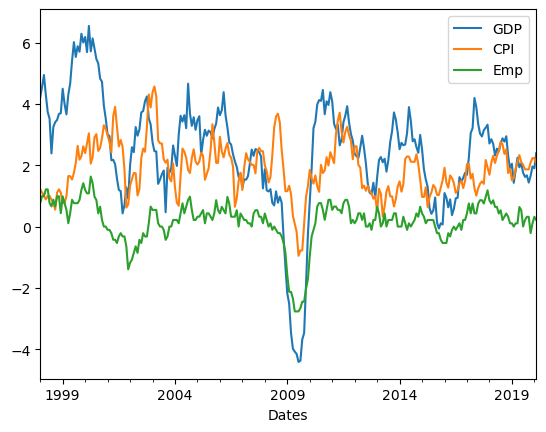

In [3]:
macro_df.plot()

In [5]:
import warnings

k = 4
initial_model = get_initial_model(data, k, 3)
print('Start iterations on sequence...')
all_seq_info = {}
all_model_info = {}
l = 1
with warnings.catch_warnings(record=True) as w:
    # Cause all warnings to always be triggered.
    warnings.simplefilter("always")
    for cl in [2, 3]:
        for cp in np.linspace(0.3, 0.7, 5):
            update_seq_info, update_model_info = fit_model_without_external(
                data, k, initial_model, l=l, cl=cl, cp=cp, log_folder='ca_logs'
            )
            all_seq_info[f'{l-1} {cl} {cp:.1f}'] = update_seq_info
            all_model_info[f'{l-1} {cl} {cp:.1f}'] = update_model_info
            print(f"Finish fitting of {l}, {cl}, {cp}")

c:\Users\Levin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Levin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Start iterations on sequence...
cp values: 3, log_file_name: l=1_cl=2_cp=3.log, logger_name: Parameters_(1_2_3)
Finish fitting of 1, 2, 0.3
cp values: 4, log_file_name: l=1_cl=2_cp=4.log, logger_name: Parameters_(1_2_4)
Finish fitting of 1, 2, 0.39999999999999997
cp values: 5, log_file_name: l=1_cl=2_cp=5.log, logger_name: Parameters_(1_2_5)
Finish fitting of 1, 2, 0.5
cp values: 6, log_file_name: l=1_cl=2_cp=6.log, logger_name: Parameters_(1_2_6)
Finish fitting of 1, 2, 0.6
cp values: 7, log_file_name: l=1_cl=2_cp=7.log, logger_name: Parameters_(1_2_7)
Finish fitting of 1, 2, 0.7
cp values: 3, log_file_name: l=1_cl=3_cp=3.log, logger_name: Parameters_(1_3_3)
Finish fitting of 1, 3, 0.3
cp values: 4, log_file_name: l=1_cl=3_cp=4.log, logger_name: Parameters_(1_3_4)
Finish fitting of 1, 3, 0.39999999999999997
cp values: 5, log_file_name: l=1_cl=3_cp=5.log, logger_name: Parameters_(1_3_5)
Finish fitting of 1, 3, 0.5
cp values: 6, log_file_name: l=1_cl=3_cp=6.log, logger_name: Parameters_

In [6]:

def plot_single(date_index, arr, plot_value, show_value, color, linestyle, ax):
    show_value -= len(np.unique(arr)) // 2 * 0.1
    index = np.where(arr[:-1] != arr[1:])[0]+1
    index = index.tolist()
    index = [0] + index + [len(arr)+1]
    for i in range(len(index)-1):
        start, end = index[i:(i+2)]
        value = arr[start]
        if value == plot_value:
            plot_index = date_index[start:end]
            ax.plot(plot_index,
                    [show_value+0.1*value]*len(plot_index),
                    color=color,
                    linestyle=linestyle,
                    linewidth=3)

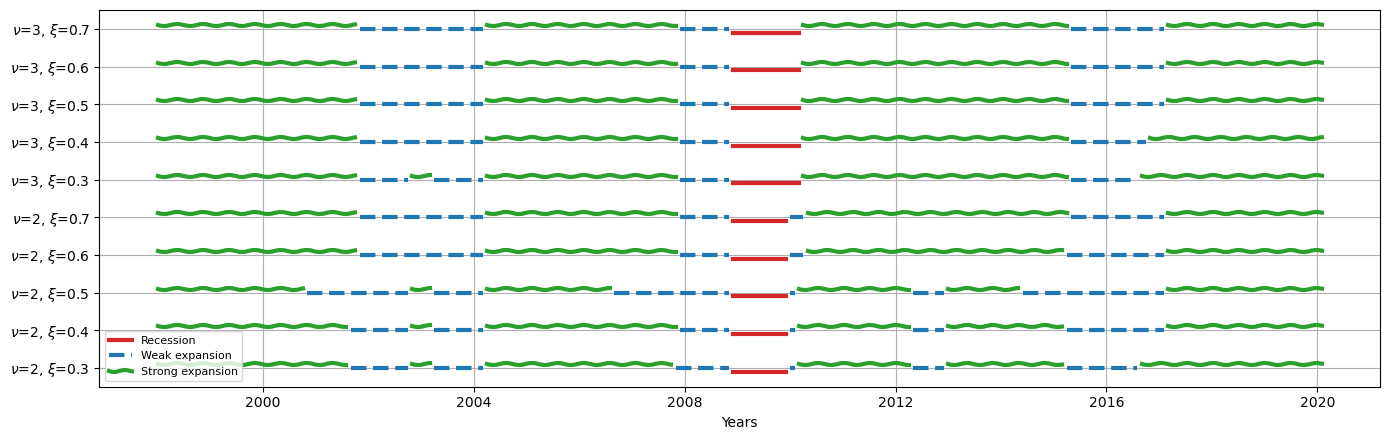

In [40]:
import matplotlib.lines as mlines
import matplotlib as mpl

date_index = macro_df.index.to_timestamp()
with mpl.rc_context({'path.sketch': (1, 20, 1)}):
    wave_line = mlines.Line2D([], [], color="tab:green", label='Strong expansion', linewidth=3)
legend_lines = [
    mlines.Line2D([], [], color="tab:red", 
                  linestyle='-', label='Recession', linewidth=3),
    mlines.Line2D([], [], color="tab:blue", 
                  linestyle='--', label='Weak expansion', linewidth=3),
    wave_line
]
y_labels = []
fig, ax = plt.subplots(figsize=(14, 4.5))
count = 0
for param, seq_info in list(all_seq_info.items()):
    y_labels.append(r'$\nu$={1}, $\xi$={2}'.format(*param.split(' ')))
    plot_single(date_index, np.array(seq_info[-1]), 0, show_value=count, color="tab:red", linestyle='-', ax=ax)
    plot_single(date_index, np.array(seq_info[-1]), 1, show_value=count, color="tab:blue", linestyle='--', ax=ax)
    with mpl.rc_context({'path.sketch': (1, 20, 1)}):
        plot_single(date_index, np.array(seq_info[-1]), 2, show_value=count, color="tab:green", linestyle=None, ax=ax)
    count += 1

ax.set(ylim=(-0.5, count-0.5),
       yticks=np.arange(count),
       yticklabels=y_labels,
       xlabel='Years')
ax.grid()
ax.legend(handles=legend_lines, fontsize=8)
fig.tight_layout()
fig.savefig('simulation_plots/canada_params_test.pdf')

In [8]:
select_model = all_model_info['0 2 0.6'][-1]

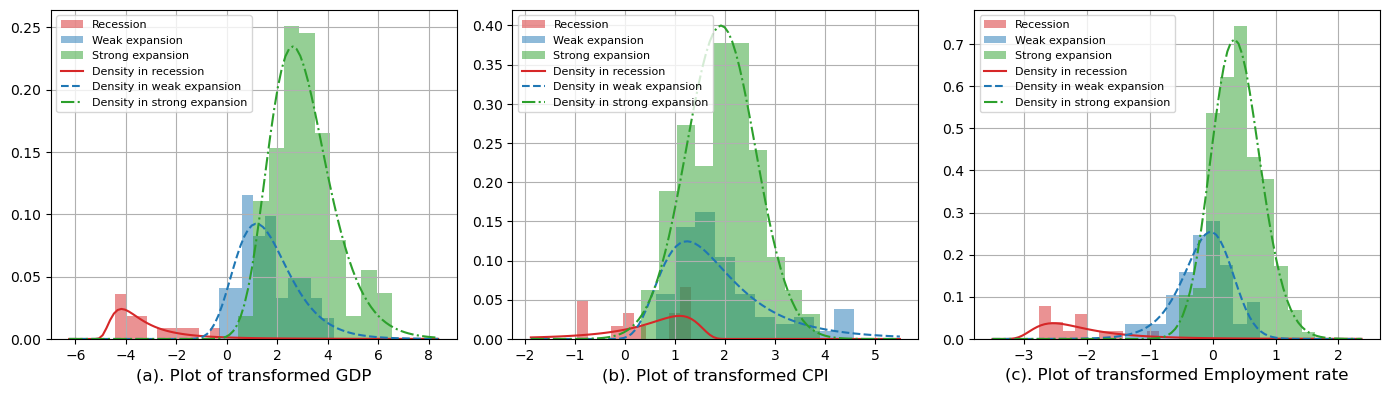

In [45]:
# plot margins
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.special import logsumexp

latent = np.array(all_seq_info['0 2 0.6'][-1])
names = ['GDP', 'CPI', 'Employment rate']
fig, axs = plt.subplots(1, 3, figsize=(14,4))
for ind in range(3):
    ax = axs[ind]

    station_pi = select_model.inference_module.get_pi()
    mgs = [copmg.margins[ind] for copmg in select_model.inference_module.copmg_arr]
    d = max(data[:,ind]) - min(data[:,ind])
    vals = np.linspace(min(data[:,ind])-d/6, max(data[:,ind])+d/6, 100)

    logpdf = np.array([m.logpdf(vals) + np.log(station_pi[i]) 
                                for (i,m) in enumerate(mgs)])
    mlogpdf = logsumexp(logpdf, axis=0)


    density, bins = np.histogram(data[latent==0,ind], density=True, bins=10)
    ax.hist(bins[:-1], bins, weights=density*station_pi[0], alpha=0.5, color='tab:red',
                label='Recession')
    density, bins = np.histogram(data[latent==1,ind], density=True, bins=10)
    ax.hist(bins[:-1], bins, weights=density*station_pi[1], alpha=0.5, color='tab:blue',
                label='Weak expansion')
    density, bins = np.histogram(data[latent==2,ind], density=True, bins=10)
    ax.hist(bins[:-1], bins, weights=density*station_pi[2], alpha=0.5, color='tab:green',
                label='Strong expansion')
    ax.plot(vals, np.exp(logpdf[0]), linestyle='-', color='tab:red', 
                label=f'Density in recession')
    ax.plot(vals, np.exp(logpdf[1]), linestyle='--', color='tab:blue', 
                label=f'Density in weak expansion')
    ax.plot(vals, np.exp(logpdf[2]), linestyle='-.', color='tab:green', 
                label=f'Density in strong expansion')
        #ax.plot(vals, np.exp(mlogpdf), label='Mixture distribution')
    ax.legend(fontsize=8)
    ax.grid()
    ax.set_title(f'({chr(ind+97)}). Plot of transformed {names[ind]}', y=-0.15)
fig.tight_layout()
fig.savefig('simulation_plots/canada_distributions.pdf')

In [54]:
from tabulate import tabulate
from scipy.special import gamma, gammaln

def mean_and_mode(pars):
    mu, sigma, a, b = pars.T
    m1 = (a-b) * np.sqrt(a+b)
    m2 = np.sqrt(2*a+1) * np.sqrt(2*b+1)
    m3 = np.exp(gammaln(a-0.5) + gammaln(b-0.5) - gammaln(a) - gammaln(b))
    return m1 * m3/2 * sigma + mu, m1 / m2 * sigma + mu

table =[]
for i in range(3):
    table.append(np.array(mean_and_mode(np.reshape(select_model.inference_module.copmg_arr[i].par, [3,4]))).flatten('F'))
print(tabulate(np.round(table,2), np.tile(['Mean','Mode'], 4), tablefmt="latex"))

\begin{tabular}{rrrrrr}
\hline
   Mean &   Mode &   Mean &   Mode &   Mean &   Mode \\
\hline
  -3.02 &  -4.18 &   0.25 &   1.1  &  -1.96 &  -2.54 \\
   1.65 &   1.17 &   1.89 &   1.24 &  -0.14 &  -0.03 \\
   3.02 &   2.61 &   1.92 &   1.92 &   0.38 &   0.34 \\
\hline
\end{tabular}


In [104]:
import array_to_latex as a2l
m = select_model.inference_module.mc_corr_arr[2].par_arr.copy()
m += np.eye(3) * 0.5
m += m.T
a2l.to_ltx(m, frmt = '{:6.2f}', arraytype = 'bmatrix', print_out=True)

\begin{bmatrix}
    1.00 &  -0.04 &    0.22\\
  -0.04 &    1.00 &  -0.05\\
    0.22 &  -0.05 &    1.00
\end{bmatrix}


In [43]:
all_model_parameters = {}
for key, values in all_model_info.items():
    all_model_parameters[key] = [m._vec_parameters() for m in values]
np.savez('canada_three_regimes.npz', all_seq_info=all_seq_info, all_model_parameters=all_model_parameters)

In [106]:
from copy import  deepcopy
mc = deepcopy(select_model.inference_module.mc_corr_arr[2])
mc.par = np.array([0.13, 0.13, 0.6])
mc.check_corr_mat()

True

In [107]:
cross_sectional_initializer()

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[ 0.01588449, -0.05036165,  0.00054472],
       [ 0.26766976,  0.1908931 ,  0.28645062],
       [-0.04180703, -0.04691664,  0.22166311]])>

In [42]:
variables_of_final_model = all_model_info['0 2 0.6'][-1].variables
%store variables_of_final_model

Stored 'variables_of_final_model' (list)


In [131]:
import pickle
select_model = all_model_info['0 2 0.6'][-1]
params = select_model._vec_parameters()
np.savez("saved_parameters/canada_params.npz", params=params)
with open("saved_parameters/im_object.pickle", "wb") as output_file:
   pickle.dump(select_model.inference_module, output_file)

In [132]:
%store -r variables_of_final_model
model = FullMCHMM(k=4, num_states=3)
model = model.get_model_from_seperate_parameters(*variables_of_final_model)
with open("saved_parameters/im_object.pickle", "rb") as input_file:
   model.inference_module = pickle.load(input_file)